<a href="https://colab.research.google.com/github/JoDeMiro/ImageProcessing/blob/main/03_Images_Example_2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Images - Examples - Baktérium növekedése

Ebben a bemutatóban baktériumok növekedését fogom vizsgálni képek alapján. A képsorozatot - Jin Park a Caltech Elowitz laboratorimának munkatársa adta közre és ingyenesen hozzáférhető.

> A baktérium tenyészetről minden 15. percben készítettek egy felvételt. Összesen 55 képet készítettek. Több mint 13 órán át figyelték a baktérium tenyészet növekedését. Ez alapján megmérték, és később becsülni tudták, hogy milyen gyorsan szaporidik a baktérium egy adott közegben.

> Tulajdonképpen ezzel a módszerel automatizálták a megfigyelés folyamatát és valójában arra voltak kíváncsiak, hogy különböző szerek hatására, hogyan változik a baktérium szaporodása.

> Ezzel a megoldással automatizálni tudták a kisérletet, és több egymástól független kísérletet tudtak elvégezni, amivel felgyorsították a kutatást.

## Ennek az egyes lépéseit szeretném bemutatni,
mert úgy gondolom, hogy a megoldás számos egyéb területen is alkalmazható.

## Lépések:

1. Beolvassuk a képsorokat, képszegmentálással elkülönítem a baktériumokat a háttértől.

2. Megmérjük a baktériumok pixelben kifejezett méretét, és a növekedés ütemét egy x,y koordinátán ábrázolom.

3. Végül a kapott adatok alapján megbecsülhetem a baktérium kolónia növekedési ütemét.



# Python könyvtárak

A szükséges Python könyvtárak között a numpy (több dimenziós tömbök kezelésére) és a skiimage könyvtár moduljai a képszegmentáláshoz.

In [2]:

import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set()

import skimage.io
import skimage.morphology
import skimage.segmentation
import skimage.measure

%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

A betöltésre kerülő képeket egy listában tárom. Késöbb ezen a listán fogok végig haladni. A képeket a saját GitHub repozitóriumomból olvasom be.

In [8]:

fn  = ['bacillus_001.tif', 'bacillus_002.tif', 'bacillus_003.tif','bacillus_004.tif', 'bacillus_005.tif', 'bacillus_006.tif', 'bacillus_007.tif', 'bacillus_008.tif', 'bacillus_009.tif', 'bacillus_010.tif',
       'bacillus_011.tif', 'bacillus_012.tif', 'bacillus_013.tif','bacillus_014.tif', 'bacillus_015.tif', 'bacillus_016.tif', 'bacillus_017.tif', 'bacillus_018.tif', 'bacillus_019.tif', 'bacillus_020.tif',
       'bacillus_021.tif', 'bacillus_022.tif', 'bacillus_023.tif','bacillus_024.tif', 'bacillus_025.tif', 'bacillus_026.tif', 'bacillus_027.tif', 'bacillus_028.tif', 'bacillus_029.tif', 'bacillus_030.tif',
       'bacillus_031.tif', 'bacillus_032.tif', 'bacillus_033.tif','bacillus_034.tif', 'bacillus_035.tif', 'bacillus_036.tif', 'bacillus_037.tif', 'bacillus_038.tif', 'bacillus_039.tif', 'bacillus_040.tif',
       'bacillus_041.tif', 'bacillus_042.tif', 'bacillus_043.tif','bacillus_044.tif', 'bacillus_045.tif', 'bacillus_046.tif', 'bacillus_047.tif', 'bacillus_048.tif', 'bacillus_049.tif', 'bacillus_050.tif',
       'bacillus_051.tif', 'bacillus_052.tif', 'bacillus_053.tif','bacillus_054.tif', 'bacillus_055.tif']

ims = []

for fname in fn:
    ims.append(skimage.io.imread('https://github.com/JoDeMiro/ImageProcessing/blob/main/images/bacteria/'+fname+'?raw=true'))
    
ims = tuple(ims)

print('There are', len(ims), 'images.')


There are 55 images.


Így néz ki az első, tizedik, huszadik, harmincadik képkocka. A képeket egyenlő időközönként készítették.

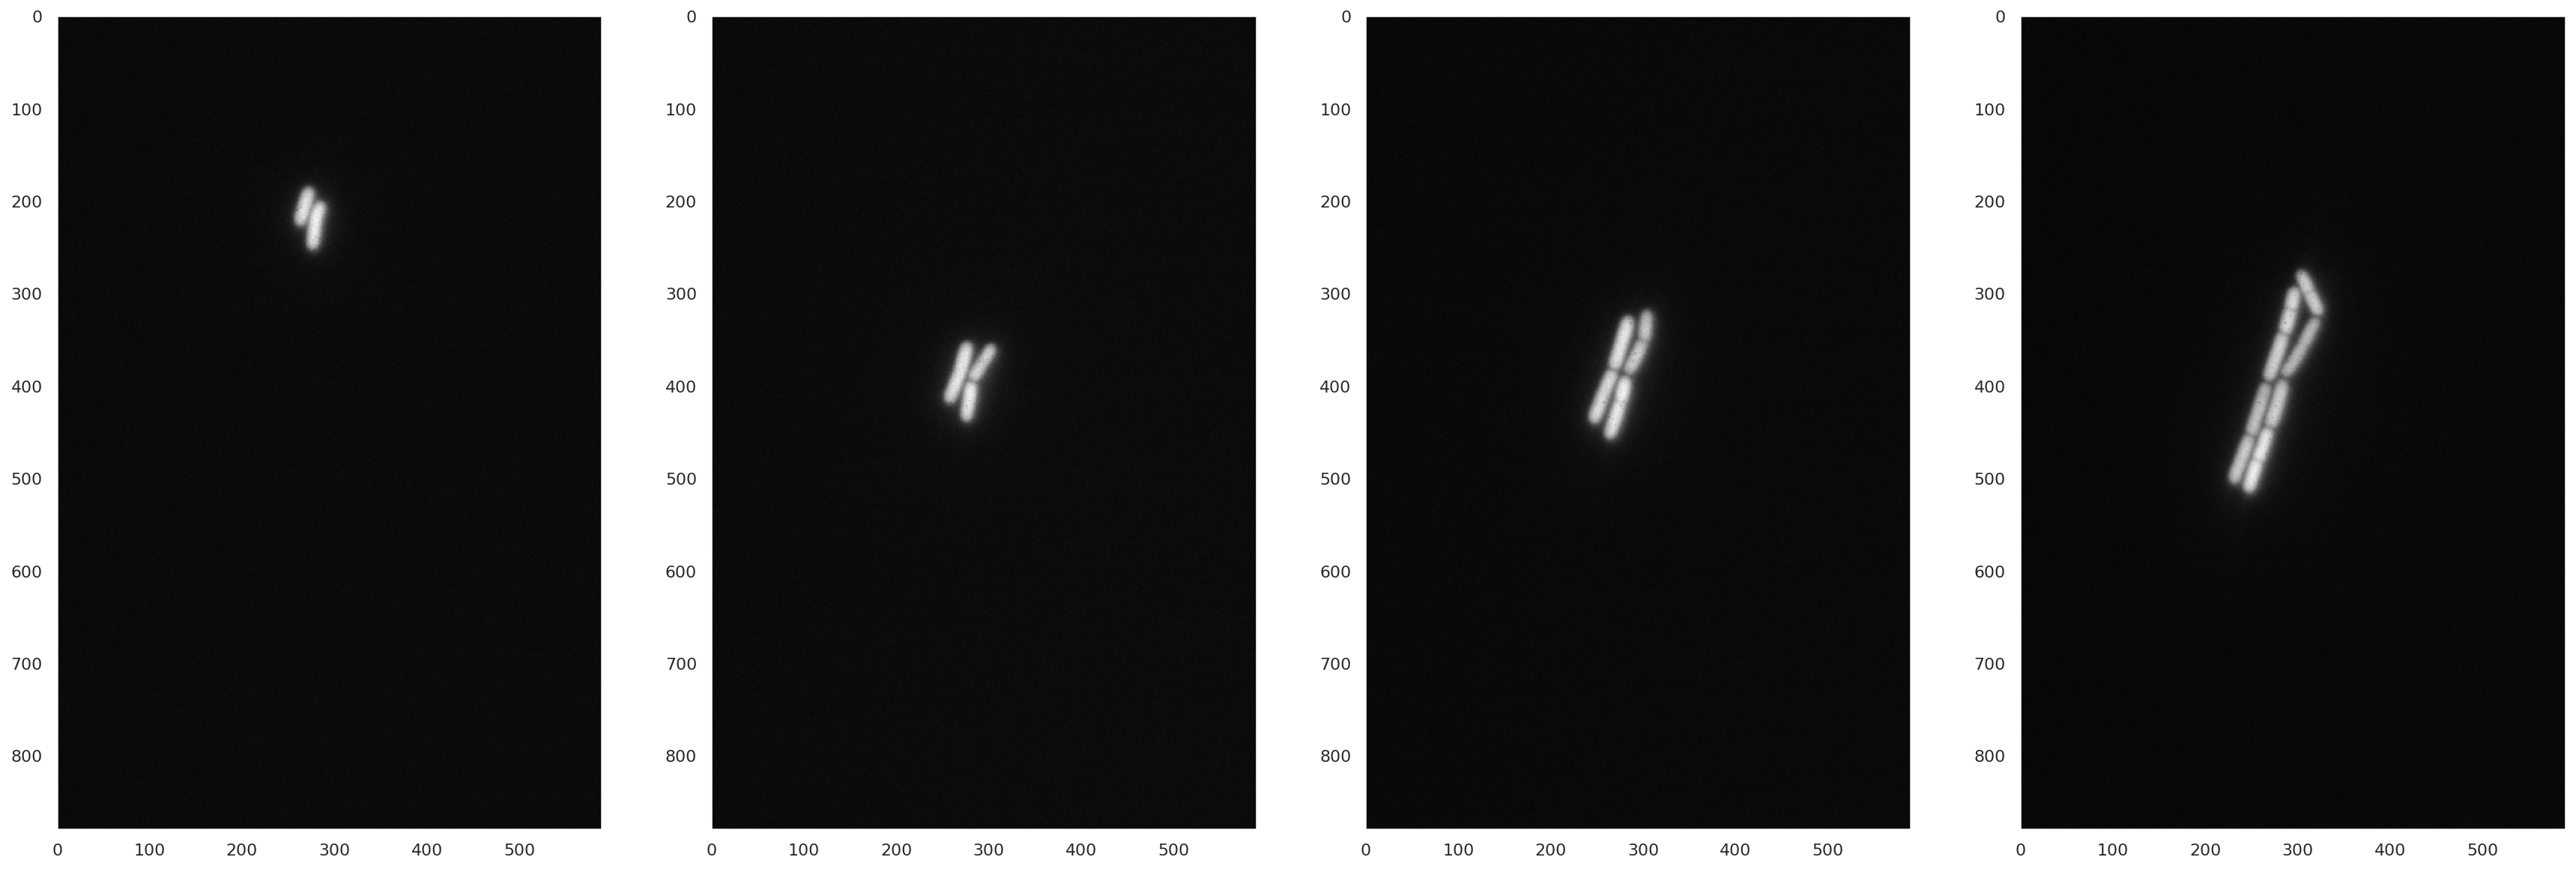

In [43]:

with sns.axes_style('dark'):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 20))
    ax1.imshow(ims[0], cmap=plt.cm.gray)
    ax2.imshow(ims[10], cmap=plt.cm.gray)
    ax3.imshow(ims[20], cmap=plt.cm.gray)
    ax4.imshow(ims[30], cmap=plt.cm.gray)

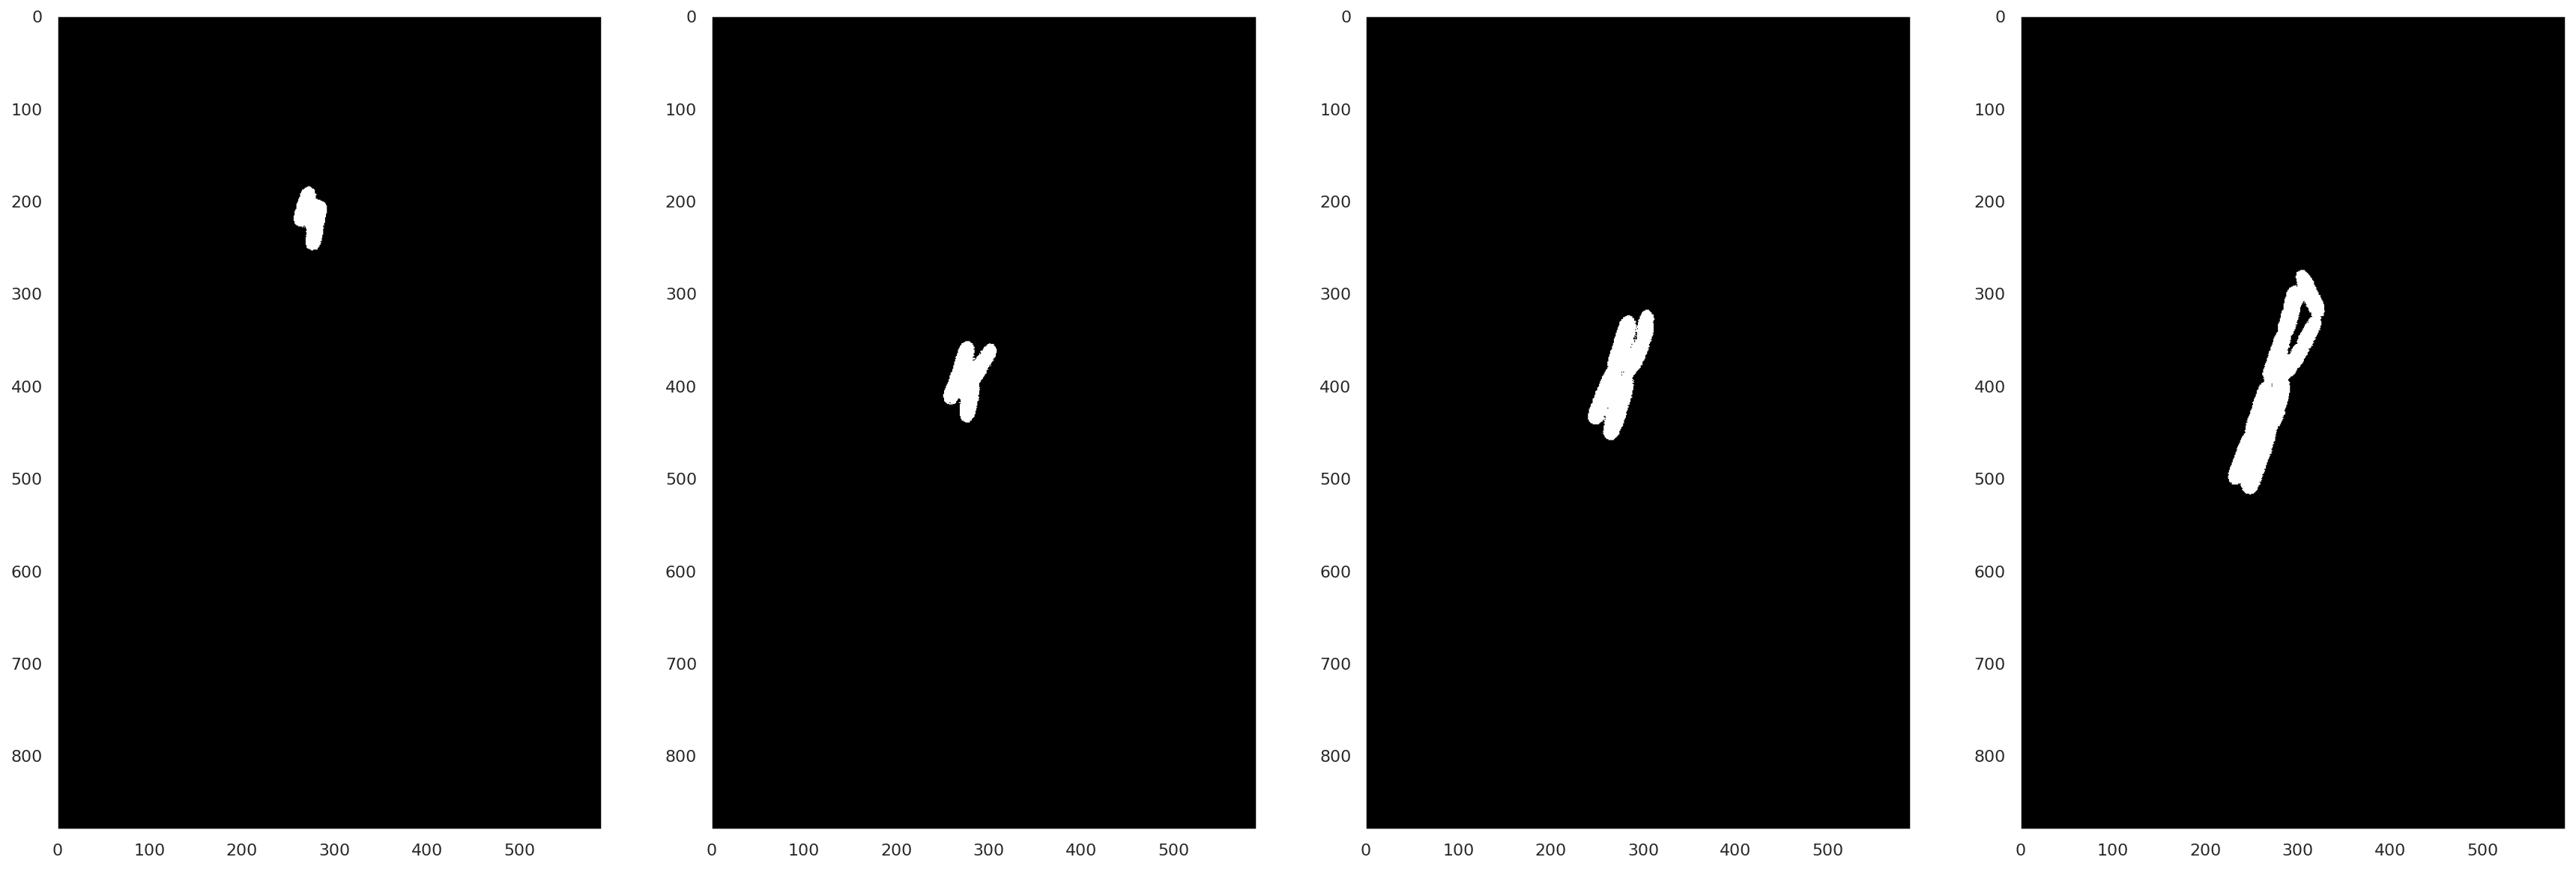

In [44]:
# Üres tároló a threshol képeknek
ims_bw = [None] * len(ims)

# Mindegyik képen alkalmazzuk az adaptív otsu threshold szűrőt
for i, im in enumerate(ims):
    thresh = skimage.filters.threshold_otsu(im)
    ims_bw[i] = im > thresh
    
# A kapott képek így néznek ki
with sns.axes_style('dark'):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 20))
    ax1.imshow(ims_bw[0], cmap=plt.cm.gray)
    ax2.imshow(ims_bw[10], cmap=plt.cm.gray)
    ax3.imshow(ims_bw[20], cmap=plt.cm.gray)
    ax4.imshow(ims_bw[30], cmap=plt.cm.gray)

# A méretek

A szerzők álltal publikált adatokból tudjuk, hogy a képen egy pixel 64.5 nanométernek felel meg. Ezért a képernyő ball alsó sarkába teszek egy 10*55 pixel fehér vonalat, amelyet a méréshez fogok felhasználni.



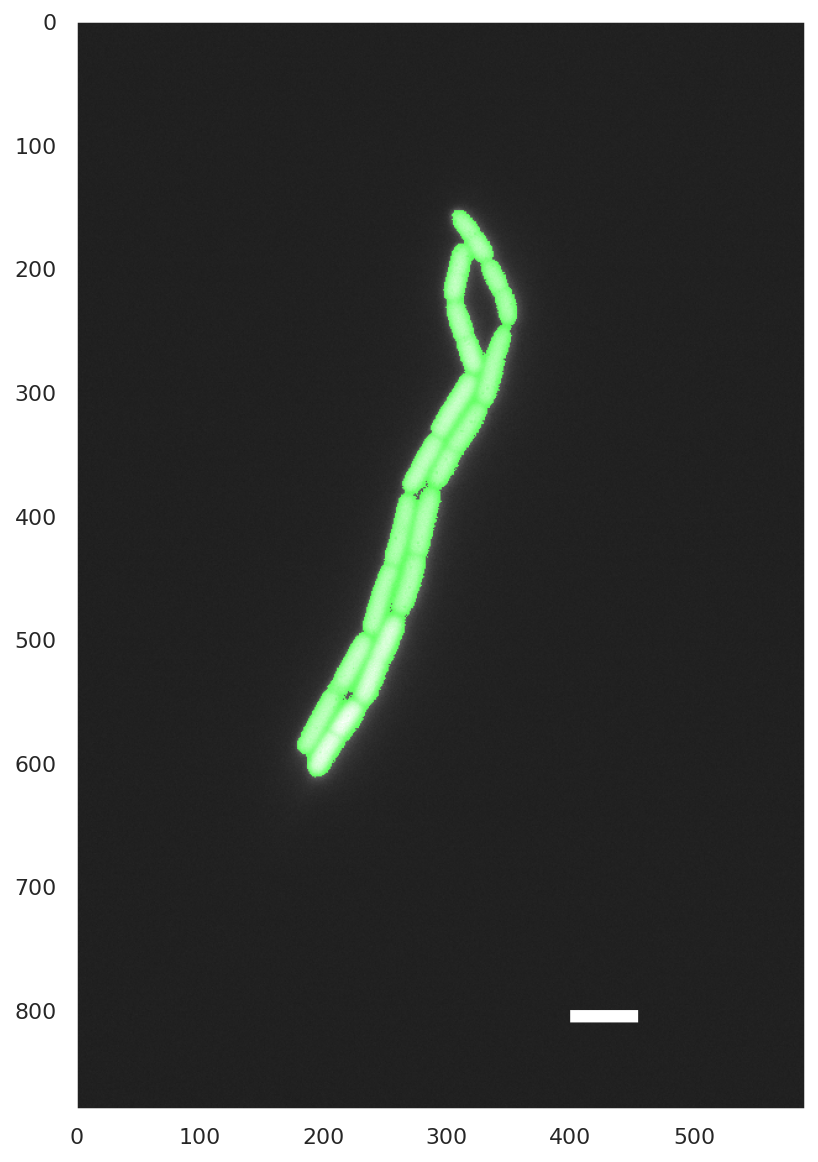

In [45]:
# Normalizáljunk egy képet, vagyis az egyes értékeit vigyük [0,1] tartományba
im = np.copy(ims[40]).astype(float)
im /= im.max()

# Készítsünk egy 10 pixel magas, 55 pixel széles mérővonalat a kép jobb alsó sarkában 
im[800:810, 400:455] = 1.0

# Az egycsatornás szürkeárnyalatos képet alakítsuk RGB képpé
im_rgb = np.dstack(3 * [im / im.max()])

# Emeljük meg a piros csatorna értékét ott ahol a threshold kép fehér
im_rgb[ims_bw[40], 1] = 1.0

# Nézzük meg az eredményt
with sns.axes_style('dark'):
  fig, ax = plt.subplots(1, 1, figsize=(10, 10))
  ax.imshow(im_rgb)

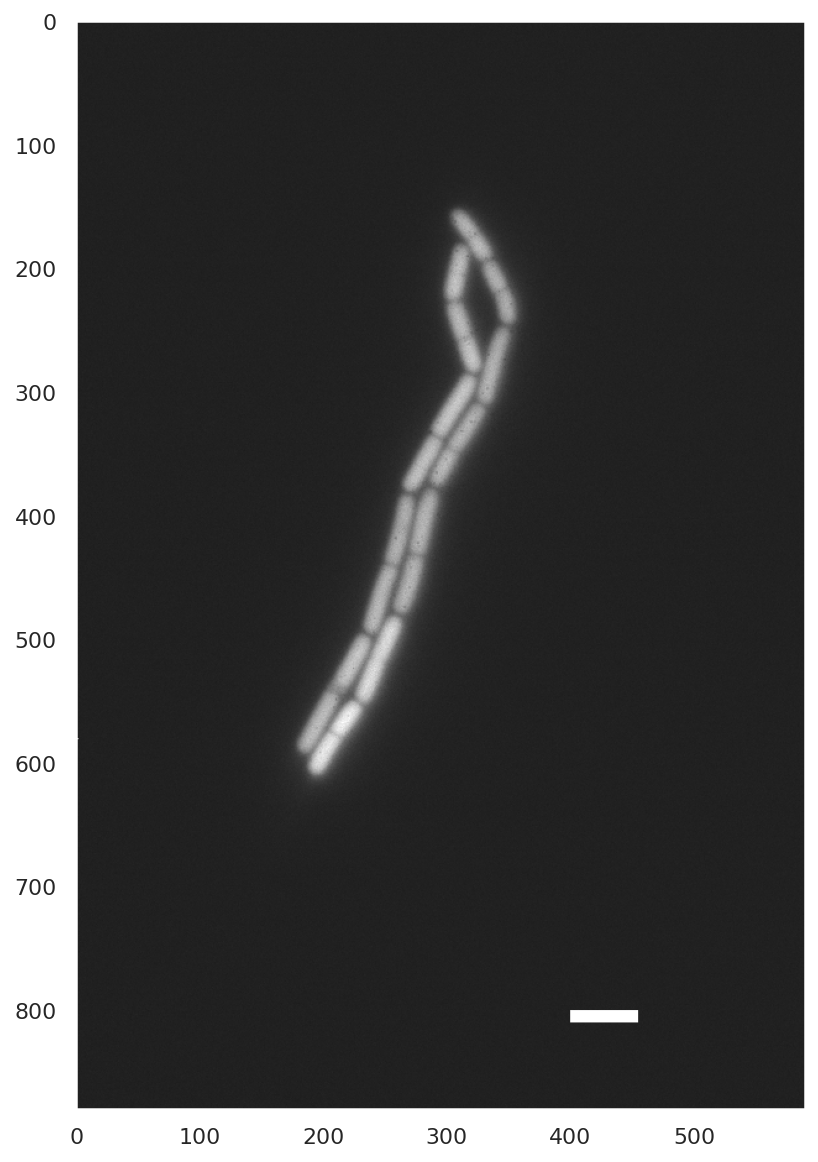

In [46]:
from skimage import filters

ims_bw = [None] * len(ims)

for i, im in enumerate(ims):
    # ims_bw[i] = skimage.filters.threshold_adaptive(im, 51)
    ims_bw[i] = skimage.filters.threshold_otsu(im, 51)
    
im = np.copy(ims[40]).astype(float)
im /= im.max()

im[800:810, 400:455] = 1.0

im_rgb = np.dstack(3 * [im / im.max()])

im_rgb[ims_bw[40], 1] = 1.0

with sns.axes_style('dark'):
  fig, ax = plt.subplots(1, 1, figsize=(10, 10))
  plt.imshow(im_rgb)

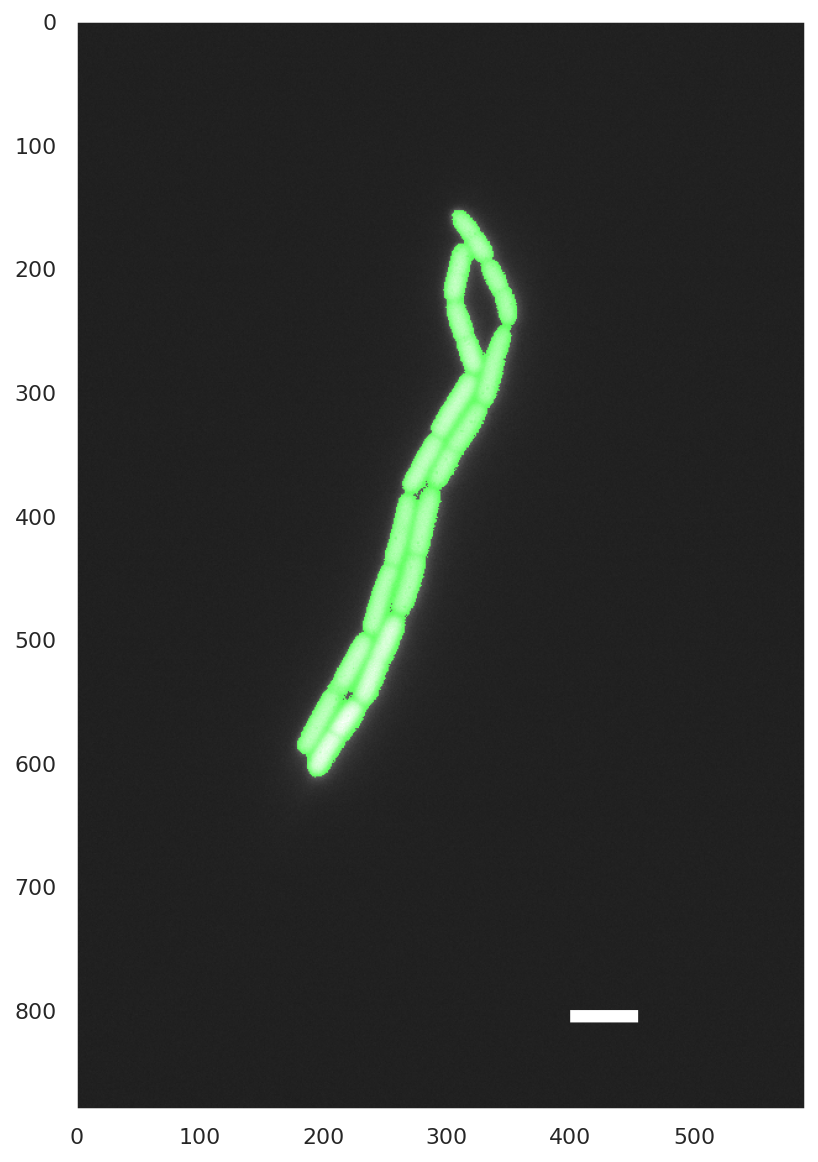

In [47]:

ims_bw = [None] * len(ims)

for i, im in enumerate(ims):
    thresh_otsu = skimage.filters.threshold_otsu(im)
    im_bw = im > thresh_otsu
    # ims_bw[i] = np.logical_and(skimage.filters.threshold_adaptive(im, 51), im_bw)
    ims_bw[i] = np.logical_and(skimage.filters.threshold_otsu(im, 51), im_bw)

im = np.copy(ims[40]).astype(float)
im /= im.max()

im[800:810, 400:455] = 1.0

im_rgb = np.dstack(3 * [im / im.max()])

im_rgb[ims_bw[40], 1] = 1.0

with sns.axes_style('dark'):
  fig, ax = plt.subplots(1, 1, figsize=(10, 10))
  ax.imshow(im_rgb)


A baktériumok által lefedett terület mérete az y tengelyen és az idő az x tengenlyen ábrázolva. A baktériumok által lefedett pixelek számát meg kell szoroznunk $(64.5 nm)^2 = 4160.25 nm2$-rel.

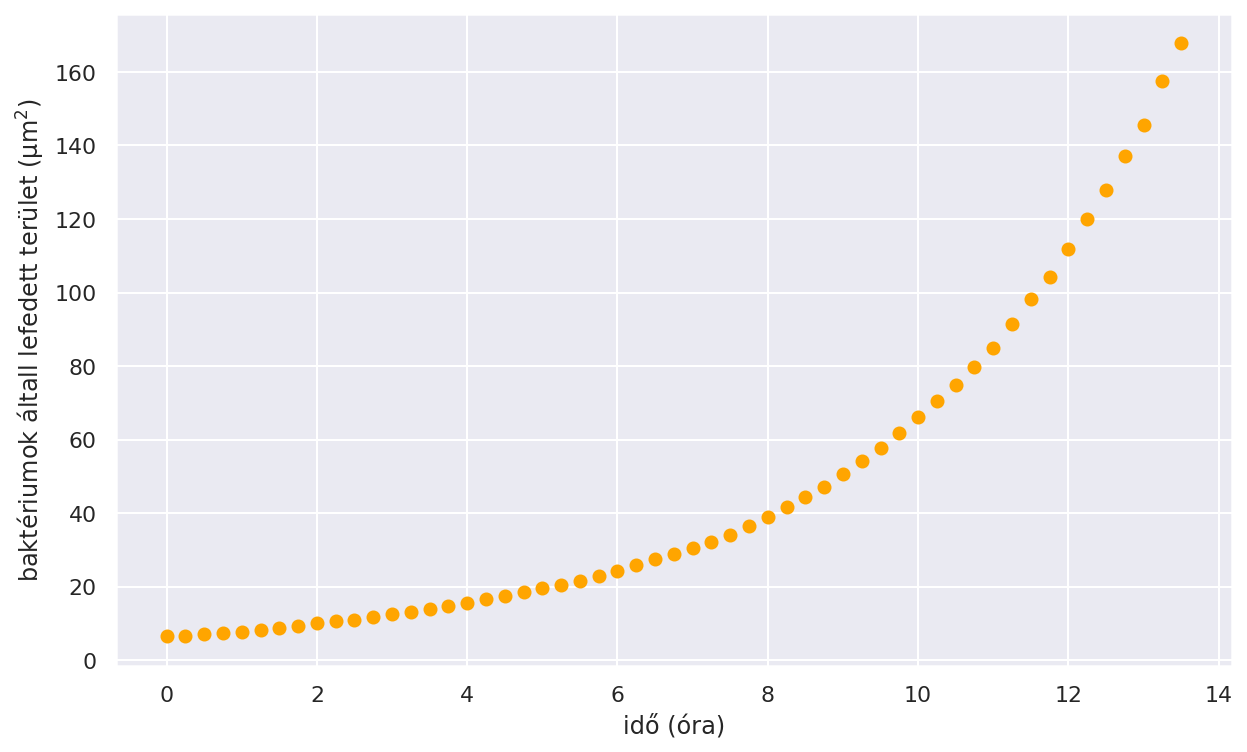

In [55]:
# 1 pixel ekkor területet fed le a valóságban
pixel_area = 0.0645**2

# A baktáriumok által lefedett terület nagysága a képen
bac_area = np.empty(len(ims_bw))
for i, im_bw in enumerate(ims_bw):
    bac_area[i] = im_bw.sum() * pixel_area
   
# Az idő
t = 0.25 * np.arange(len(ims_bw))

# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(t, bac_area, marker='.', linestyle='', markersize=12, color='orange')
ax.set_xlabel('idő (óra)')
ax.set_ylabel('baktériumok általl lefedett terület (µm$^2$)')
plt.show()

# Becslés,  mérés

Feltéve, hogy az idő és a terület nagysága között exponenciális összefüggés van.

$$b(t) =  b_0 e^{t/\tau}$$

Vehetnénk az adatok logaritmusát és lineáris regresszióval közelítenénk, de itt most egy másik eljárást használok.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until



b_0 = 5.03 sq. µm
  τ = 3.86 óra



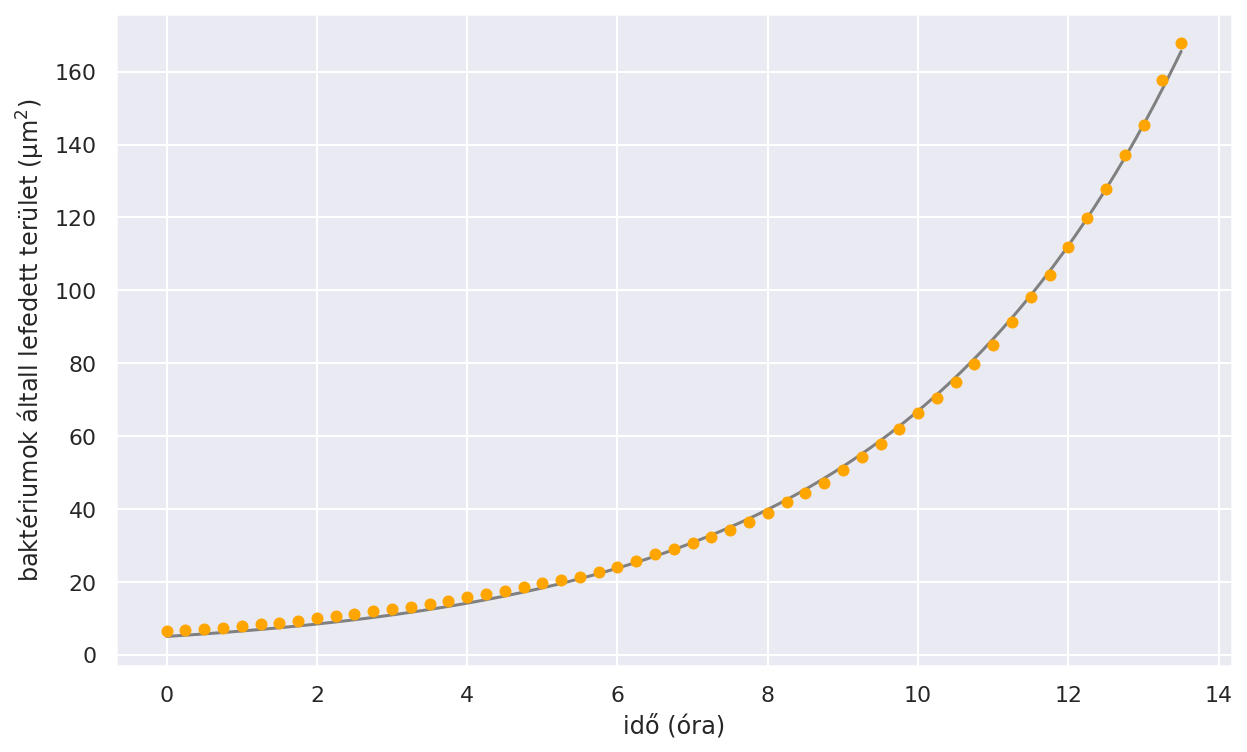

In [57]:
# Az illeszkedés
def exp_growth(t, log_b_0, log_tau):
    return np.exp(log_b_0) * np.exp(t / np.exp(log_tau))

# Random guess
p0 = np.log(np.array([5.0, 12.0]))

# Görbeillesztés
log_p, _ = scipy.optimize.curve_fit(exp_growth, t, bac_area, p0)


print("""
b_0 = {0:.2f} sq. µm
  τ = {1:.2f} óra
""".format(*tuple(np.exp(log_p))))

t_smooth = np.linspace(0, t.max(), 200)
y_smooth = exp_growth(t_smooth, *tuple(log_p))

# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(t_smooth, y_smooth, marker='None', linestyle='-', color='gray')
ax.plot(t, bac_area, marker='.', linestyle='', markersize=10, color='orange')
ax.set_xlabel('idő (óra)')
ax.set_ylabel('baktériumok általl lefedett terület (µm$^2$)')
plt.show()

## Eredmény

Tehát körülbelül 3.86 óra alatt duplázódik meg a baktérium popupuláció.

## A teljes program egyben

Kétféle módszerrel is készülhetnek képek és most a kétféle módszerrel készített képek alapján készült méréseket fogjuk összehasonlítani.

A kutatók rendelkezésre bocsájtottak egy másik eljárással készült képsorozatot is. Ez alapján össze tudjuk hasonlítani a kétféle módszert. Bár lehet, hogy nem
lesz különbség a két módszer között, ez megmarad kutatási kérdésnek.

In [58]:
def cell_segmenter(im, thresh='otsu', radius=20.0, image_mode='phase',
                   area_bounds=(0,1e7), ecc_bounds=(0, 1)):
    """
    Ez a függvény egy adott képet szegmentál a képpont intenzitása alapján.
    Visszatérési érétke egy szegmentációs mask, amely az eredeti képpel azonos
    dimenziójú és True, False értékeket tartalmaz.
    
    Parameters
    ----------
    im : 2d-array
        A kép amelyet szegmentálni szeretnénk. Ez lehet float vagy
        integer adat típus is.
    thresh : int, float, vagy 'otsu'
        Az küszöbéréték amelyet a szegmentációhoz használunk.
        Ha 'otsu' akkor 'otsu', a küszöbértéék az Otsu algoritmus szerint lesz
        meghatározva.
    radius : float
        A Gauss filter sigma értéke - szórása. Alapbeállítása 20.
    image_mode : 'phase' vagy 'fluorescence'
        Attól függően, hogy az adott képet milyen mikroszkóp beállítás mellett
        készítetették lehet 'phase' ahol a kép intezitása alacsonyabb
        Attól függően, hogy melyik módszert választjuk a maszk elkészítésénél
        a küszöbérték alatti vagy fölötti terület alapján kerül kiszámításra.
    area_bounds : tuple of ints.
        Egy különálló objektum minimális mérete. Ezt a pixelek négyzetének
        számában adjuk meg.
    ecc_bounds : tuple of floats
        Variabilitás, érétke 0 és 1 közötti lebegőpontos
        
    Returns
    -------
    im_labeled : 2d-array, int
        Címkézett szegmentációs maszk.
    """
     
    # Medián szűrő alkalmazása a kiugró értékek kezelésére
    med_selem = skimage.morphology.square(3)
    im_filt = skimage.filters.median(im, selem=med_selem)
   
    # Perform gaussian subtraction
    im_sub = bg_subtract(im_filt, radius)
    
    # A threshold módszer meghatározása - csak 'otsu'
    if thresh is 'otsu':
        thresh = skimage.filters.threshold_otsu(im_sub)

    # A küszöbérték számításának módja
    if image_mode is 'phase':
        im_thresh = im_sub < thresh
    elif image_mode is 'fluorescence':
        im_thresh = im_sub > thresh
    else:
        raise ValueError("a paraméter nem megfelelő. Vagy 'phase' "
                          + " vagy 'fluorescence'")
       
    # Az objektumok megjelölése
    im_label = skimage.measure.label(im_thresh)

    # A terület kiszámolása 
    im_filt = area_ecc_filter(im_label, area_bounds, ecc_bounds)
    
    # A képszélen lévő elemek eltávolítása
    im_border = skimage.segmentation.clear_border(im_filt, buffer_size=5)
    
    # Újraszámolás
    im_border = im_border > 0 
    im_label = skimage.measure.label(im_border)
    
    return im_label


def bg_subtract(im, radius):
    """
    Kivonja a Gauss szűrővel simított képet saját magából, hogy a nem kívánt
    fényerejű hatásokat csökkentse. Előfeldolgozás a szegmentáció előtt.
    
    Parameters
    ----------
    im : 2d-array
        A kép Numpy.arrary formátumban
    radius : int vagy float
        Az élsimítás rádiusza
    
    Returns
    -------
    im_sub : 2d-array, float
        Kép.
    """
    
    # Gauss filter
    im_filt = skimage.filters.gaussian(im, radius)
    
    # Ellenőrző kód, hogy a kép float és nem int.
    if np.max(im) > 1.0:
        im = skimage.img_as_float(im)
    
    im_sub = im - im_filt
    
    return  im_sub


def area_ecc_filter(im, area_bounds, ecc_bounds):
    """
    Filters objects in an image based on their areas.
    
    Parameters
    ----------
    im : 2d-array, int
        A felcímkézett maszk amin a szűrést végrehajtjuk
    area_bounds : tuple of ints
        A legkisebb terület ami alatt már nem fogadjuk el különálló
        objektumnak
    ecc_bounds : tuple of floats 
        Távolság amelyen belül két különálló objektum nem lehet.
        Értéke 0 és 1 között van.
        
    Returns
    -------
    im_relab : 2d-array, int
        Az újra címkézett kép
    """
 
    # Ezt kívülről másoltam, még nem pontosan értem a működését.
    # Extract the region props of the objects. 
    props = skimage.measure.regionprops(im)
    
    # Extract the areas and labels.
    areas = np.array([prop.area for prop in props])
    eccs = np.array([prop.eccentricity for prop in props])
    labels = np.array([prop.label for prop in props])

    # Make an empty image to add the approved cells.
    im_approved = np.zeros_like(im)
    
    # Threshold the objects based on area and eccentricity
    for i, _ in enumerate(areas):
        if areas[i] > area_bounds[0] and areas[i] < area_bounds[1]\
            and eccs[i] > ecc_bounds[0] and eccs[i] < ecc_bounds[1]:
                im_approved += im==labels[i]
   
    # Relabel the image.
    im_filt = skimage.measure.label(im_approved > 0)
    return im_filt

# A kétféle eljárással készült képek összehasonlítása

1. Iteráljunk végigk az összes 'phase' eljárással készült képen

2. Végezzük el mindegyik képen a szegmentálást.

3. Mérjük meg az átlagos pixel intenzitás mértékét minden szegmentált objektumon.

4. Tároljuk el az így kapott értékeket egy listában.

In [27]:

phase_ims  = ['noLac_phase_0000.tif', 'noLac_phase_0001.tif', 'noLac_phase_0002.tif', 'noLac_phase_0003.tif',
              'noLac_phase_0004.tif', 'noLac_phase_0005.tif', 'noLac_phase_0006.tif', 'noLac_phase_0007.tif',
              'noLac_phase_0008.tif']

fluo_ims  = ['noLac_FITC_0000.tif', 'noLac_FITC_0001.tif', 'noLac_FITC_0002.tif', 'noLac_FITC_0003.tif',
             'noLac_FITC_0004.tif', 'noLac_FITC_0005.tif', 'noLac_FITC_0006.tif', 'noLac_FITC_0007.tif',
             'noLac_FITC_0008.tif']

phase_ims.sort()
fluo_ims.sort()


In [59]:
# üres lista amelyben mindegy egyes baktériumhoz tartozó pixel intezitás átla-
# gát fogom tárolni.
mean_ints = []

# egy másik tároló.
areas = []

ip_dist = 0.0636  # µm per pixel
area_bounds = (0.5/ip_dist**2, 4/ip_dist**2)
ecc_bounds = (0.8, 1.0)

# végig iterálunk az összes képen
for p, f in zip(phase_ims, fluo_ims):
    # Load the phase image.
    phase_im = skimage.io.imread('https://github.com/JoDeMiro/ImageProcessing/blob/main/images/bacteria/h5/'+p+'?raw=true')
    
    # Szegmentáció
    phase_seg = cell_segmenter(phase_im, image_mode='phase', 
                               area_bounds=area_bounds, ecc_bounds=ecc_bounds)
    
    # Load the fluorescence image.
    fluo_im = skimage.io.imread('https://github.com/JoDeMiro/ImageProcessing/blob/main/images/bacteria/h5/'+f+'?raw=true')
    
    # A régiók kiszámolása
    props = skimage.measure.regionprops(phase_seg, intensity_image=fluo_im)
    
    # A régiókhoz tartozó pixelek intenzitásának átlaga és a terület hozzáadása a listához 
    for prop in props:
        mean_ints.append(prop.mean_intensity)
        areas.append(prop.area * ip_dist**2)
        
    
# Átkonvertálom a listát Numpy.array formátumba
mean_ints = np.array(mean_ints)
areas = np.array(areas)

# Vessünk egy pillantást az utoljára szegmentált képre

Ellenőrzés gyanánt.

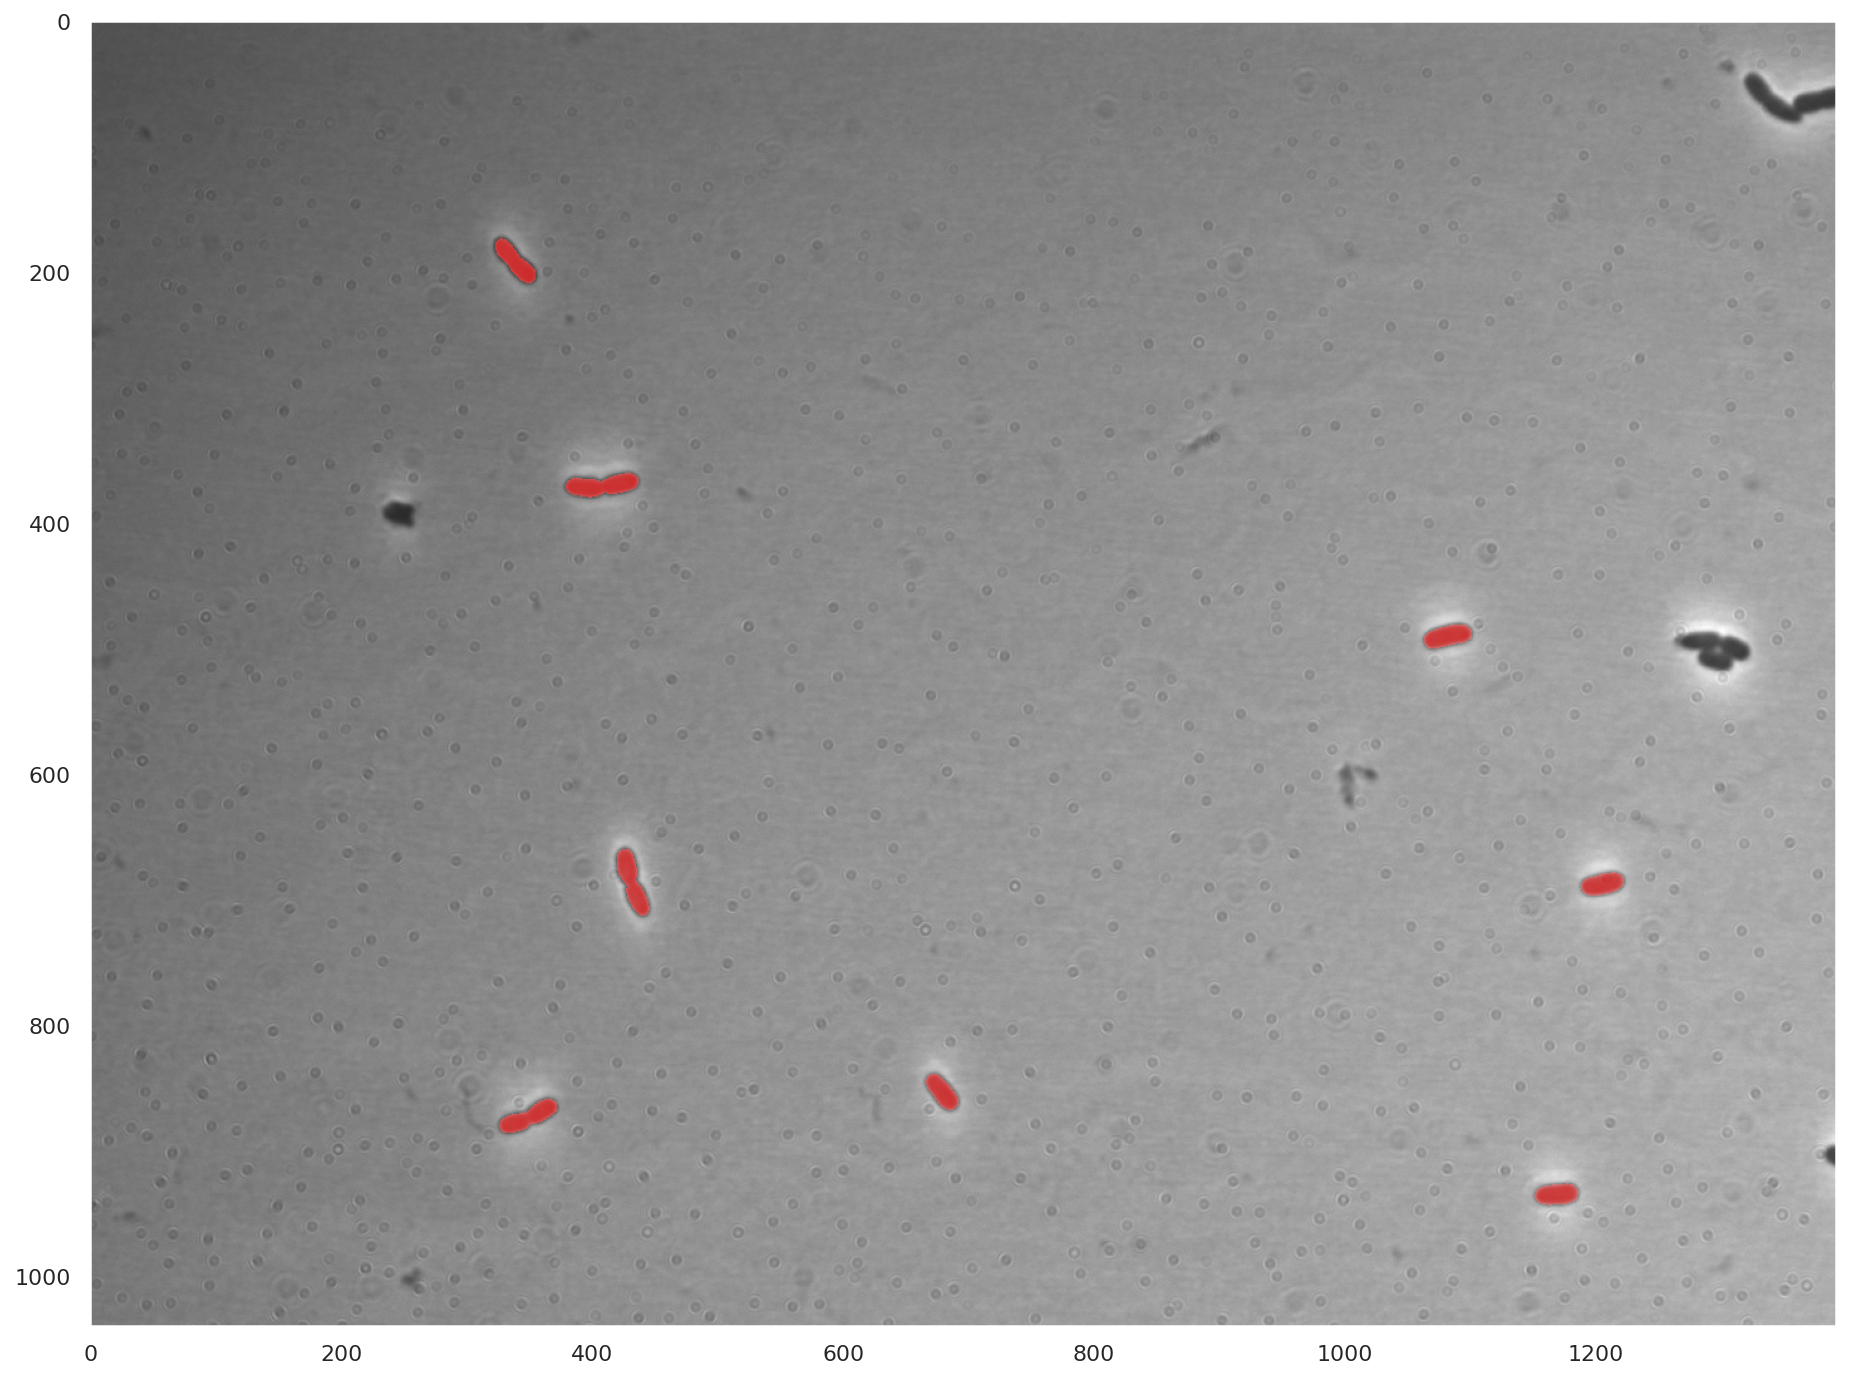

In [61]:
# Átkonvertálom a képet lebegőpontos formátumba [0,1] tartomány közé
phase_float = phase_im / phase_im.max()
phase_float_copy = np.copy(phase_float)

# Megjelelöm azokat a pontokat a képen ahol a szegmentációs maszk True
# értéket vett fel 
phase_float_copy[phase_seg > 0] = 0.8

# Megszinezem a szegmentált részeket
merge = np.dstack((phase_float_copy, phase_float, phase_float))

# Plot
with sns.axes_style('dark'):
  fig, ax = plt.subplots(1, 1, figsize=(20, 12))
  ax.imshow(merge)
  plt.show()
    

In [62]:
# Az összes kép során ennyi baktériumot elemeztünk és mértük meg rajtuk
# a lefedett területet.
print("Szegmentált és kiértékelt baktériumok száma {num}.".format(num=len(mean_ints)))

Szegmentált és kiértékelt baktériumok száma 93.
